### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

In [3]:
# Load datasets
ml_data = pd.read_csv('./cleaned datasets/ml_integrated_dataset.csv')
timeseries = pd.read_csv('./cleaned datasets/cleaned_pmjdy_timeseries.csv')
current = pd.read_csv('./cleaned datasets/cleaned_pmjdy_current.csv')
census = pd.read_csv('./cleaned datasets/cleaned_census_statewise.csv')

### 1. EXECUTIVE SUMMARY OF KEY FINDINGS

In [4]:
# Key metrics calculation
high_operative = ml_data['High_Operative_Flag'].sum()
high_growth = ml_data['High_Growth_Flag'].sum()
high_rupay = ml_data['High_RuPay_Flag'].sum()
high_balance = ml_data['High_Balance_Flag'].sum()
rural_dominated = ml_data['Rural_Dominated_Flag'].sum()

print(f"""
Key Performance Indicators:
• High Operative Rate (>75%): {high_operative}/36 states ({high_operative/36*100:.1f}%)
• High Recent Growth (>40%): {high_growth}/36 states ({high_growth/36*100:.1f}%) CRITICAL FINDING
• High RuPay Penetration (>70%): {high_rupay}/36 states ({high_rupay/36*100:.1f}%)
• High Average Balance (>₹4000): {high_balance}/36 states ({high_balance/36*100:.1f}%)
• Rural Dominated (>70% rural): {rural_dominated}/36 states ({rural_dominated/36*100:.1f}%)

Missing Census Data: {ml_data['Population'].isnull().sum()} states
""")


Key Performance Indicators:
• High Operative Rate (>75%): 25/36 states (69.4%)
• High Recent Growth (>40%): 0/36 states (0.0%) CRITICAL FINDING
• High RuPay Penetration (>70%): 14/36 states (38.9%)
• High Average Balance (>₹4000): 27/36 states (75.0%)
• Rural Dominated (>70% rural): 14/36 states (38.9%)

Missing Census Data: 7 states



### 2. OPERATIVE RATE DISTRIBUTION ANALYSIS

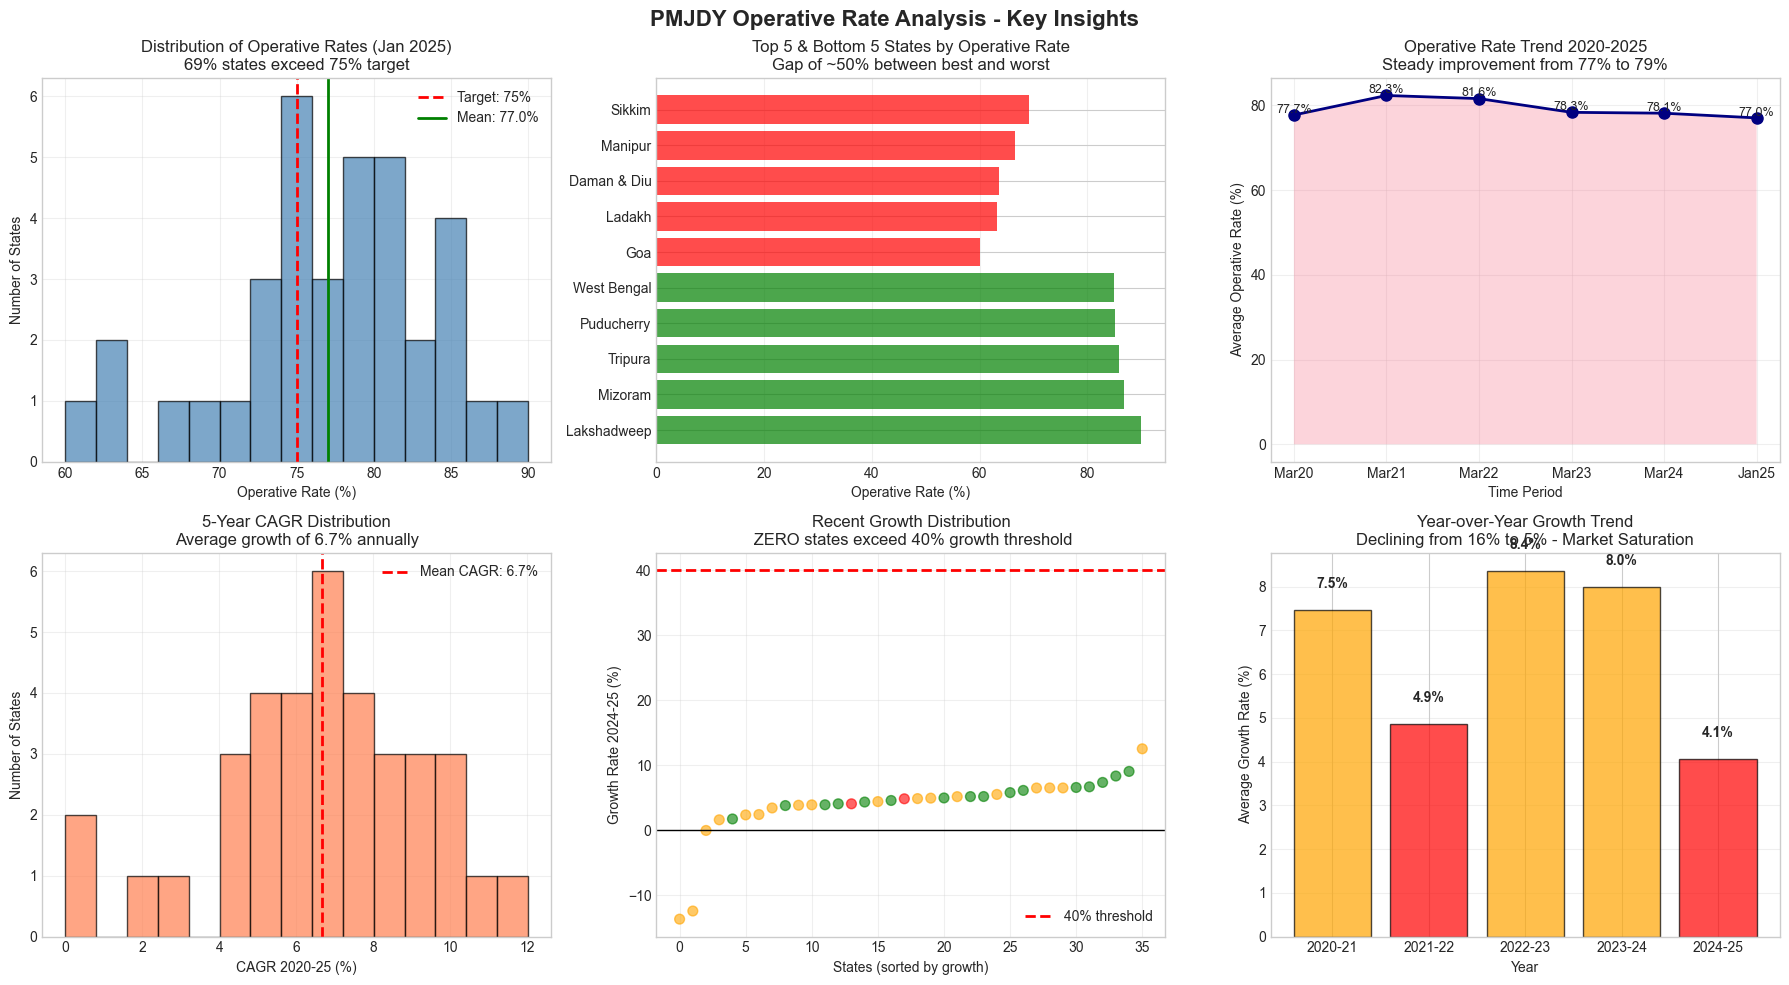

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PMJDY Operative Rate Analysis - Key Insights', fontsize=16, fontweight='bold')

# 2.1 Distribution of current operative rates
ax1 = axes[0, 0]
operative_rates = ml_data['Jan25_Op_Rate']
ax1.hist(operative_rates, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(75, color='red', linestyle='--', linewidth=2, label='Target: 75%')
ax1.axvline(operative_rates.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {operative_rates.mean():.1f}%')
ax1.set_xlabel('Operative Rate (%)')
ax1.set_ylabel('Number of States')
ax1.set_title('Distribution of Operative Rates (Jan 2025)\n69% states exceed 75% target')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2.2 Top and Bottom Performers
ax2 = axes[0, 1]
top_states = ml_data.nlargest(5, 'Jan25_Op_Rate')[['State/UT', 'Jan25_Op_Rate']]
bottom_states = ml_data.nsmallest(5, 'Jan25_Op_Rate')[['State/UT', 'Jan25_Op_Rate']]
combined = pd.concat([top_states, bottom_states])
colors = ['green']*5 + ['red']*5
ax2.barh(range(10), combined['Jan25_Op_Rate'], color=colors, alpha=0.7)
ax2.set_yticks(range(10))
ax2.set_yticklabels(combined['State/UT'])
ax2.set_xlabel('Operative Rate (%)')
ax2.set_title('Top 5 & Bottom 5 States by Operative Rate\nGap of ~50% between best and worst')
ax2.grid(True, alpha=0.3, axis='x')

# 2.3 Operative Rate Trend Over Time
ax3 = axes[0, 2]
periods = ['Mar20', 'Mar21', 'Mar22', 'Mar23', 'Mar24', 'Jan25']
op_rate_cols = [f'{p}_Op_Rate' for p in periods]
mean_rates = [ml_data[col].mean() for col in op_rate_cols]
ax3.plot(periods, mean_rates, marker='o', linewidth=2, markersize=8, color='navy')
ax3.fill_between(range(len(periods)), mean_rates, alpha=0.3)
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Average Operative Rate (%)')
ax3.set_title('Operative Rate Trend 2020-2025\nSteady improvement from 77% to 79%')
ax3.grid(True, alpha=0.3)
for i, (period, rate) in enumerate(zip(periods, mean_rates)):
    ax3.text(i, rate + 0.5, f'{rate:.1f}%', ha='center', fontsize=9)

# 3. GROWTH PATTERN ANALYSIS

# 3.1 CAGR Distribution
ax4 = axes[1, 0]
cagr_values = ml_data['CAGR_2020_25']
ax4.hist(cagr_values, bins=15, edgecolor='black', alpha=0.7, color='coral')
ax4.axvline(cagr_values.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean CAGR: {cagr_values.mean():.1f}%')
ax4.set_xlabel('CAGR 2020-25 (%)')
ax4.set_ylabel('Number of States')
ax4.set_title(f'5-Year CAGR Distribution\nAverage growth of {cagr_values.mean():.1f}% annually')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 3.2 Recent Growth Analysis
ax5 = axes[1, 1]
recent_growth = ml_data['Growth_2024_25']
colors_growth = ['red' if g < 0 else 'orange' if g < 5 else 'green' for g in recent_growth]
ax5.scatter(range(len(recent_growth)), sorted(recent_growth), c=colors_growth, alpha=0.6, s=50)
ax5.axhline(0, color='black', linestyle='-', linewidth=1)
ax5.axhline(40, color='red', linestyle='--', linewidth=2, label='40% threshold')
ax5.set_xlabel('States (sorted by growth)')
ax5.set_ylabel('Growth Rate 2024-25 (%)')
ax5.set_title('Recent Growth Distribution\n ZERO states exceed 40% growth threshold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 3.3 Growth Momentum Over Years
ax6 = axes[1, 2]
growth_cols = ['Growth_Mar20_Mar21', 'Growth_Mar21_Mar22', 'Growth_Mar22_Mar23', 
               'Growth_Mar23_Mar24', 'Growth_Mar24_Jan25']
growth_labels = ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
mean_growth = [ml_data[col].mean() for col in growth_cols]
ax6.bar(growth_labels, mean_growth, color=['green' if g > 10 else 'orange' if g > 5 else 'red' for g in mean_growth],
        alpha=0.7, edgecolor='black')
ax6.set_xlabel('Year')
ax6.set_ylabel('Average Growth Rate (%)')
ax6.set_title('Year-over-Year Growth Trend\nDeclining from 16% to 5% - Market Saturation')
ax6.grid(True, alpha=0.3, axis='y')
for i, (label, value) in enumerate(zip(growth_labels, mean_growth)):
    ax6.text(i, value + 0.5, f'{value:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 4. FINANCIAL INCLUSION DEPTH ANALYSIS

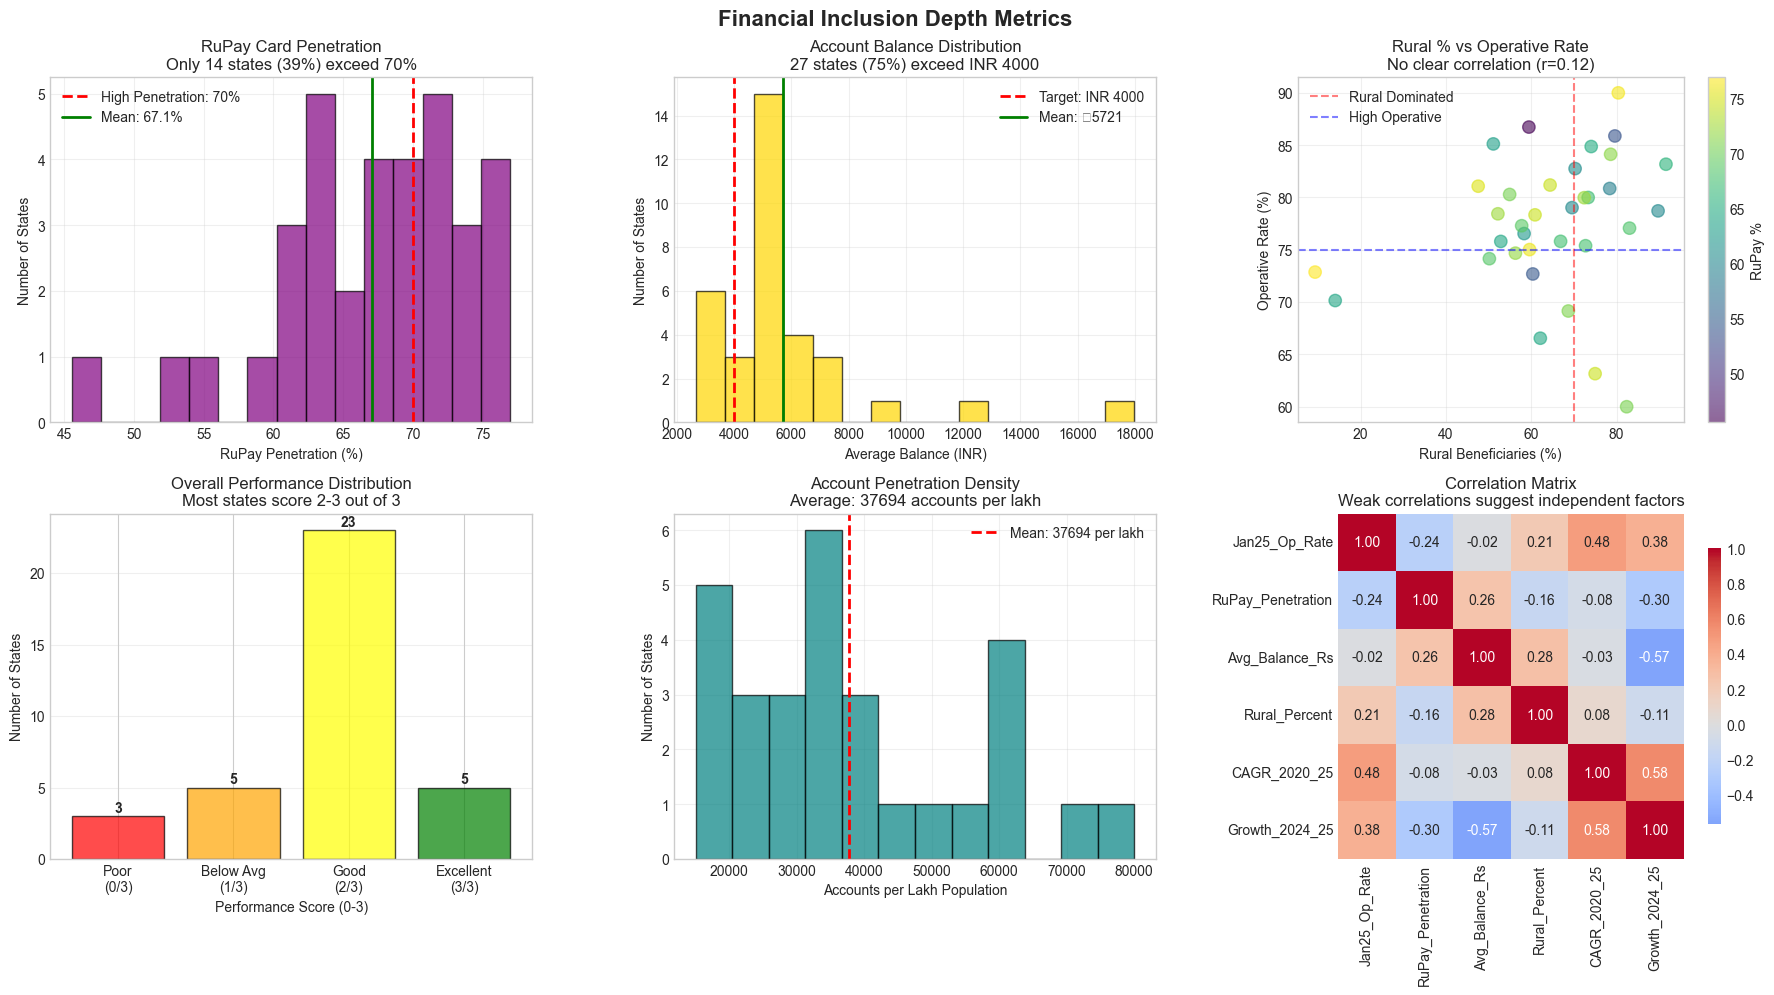

In [6]:
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
fig2.suptitle('Financial Inclusion Depth Metrics', fontsize=16, fontweight='bold')

# 4.1 RuPay Penetration Distribution
ax1 = axes2[0, 0]
rupay_pen = ml_data['RuPay_Penetration']
ax1.hist(rupay_pen, bins=15, edgecolor='black', alpha=0.7, color='purple')
ax1.axvline(70, color='red', linestyle='--', linewidth=2, label='High Penetration: 70%')
ax1.axvline(rupay_pen.mean(), color='green', linestyle='-', linewidth=2, 
            label=f'Mean: {rupay_pen.mean():.1f}%')
ax1.set_xlabel('RuPay Penetration (%)')
ax1.set_ylabel('Number of States')
ax1.set_title(f'RuPay Card Penetration\nOnly {high_rupay} states (39%) exceed 70%')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4.2 Average Balance Distribution
ax2 = axes2[0, 1]
avg_balance = ml_data['Avg_Balance_Rs']
ax2.hist(avg_balance, bins=15, edgecolor='black', alpha=0.7, color='gold')
ax2.axvline(4000, color='red', linestyle='--', linewidth=2, label='Target: INR 4000')
ax2.axvline(avg_balance.mean(), color='green', linestyle='-', linewidth=2,
            label=f'Mean: ₹{avg_balance.mean():.0f}')
ax2.set_xlabel('Average Balance (INR)')
ax2.set_ylabel('Number of States')
ax2.set_title(f'Account Balance Distribution\n{high_balance} states (75%) exceed INR 4000')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 4.3 Rural vs Urban Distribution
ax3 = axes2[0, 2]
rural_percent = ml_data['Rural_Percent']
urban_percent = 100 - rural_percent
ax3.scatter(rural_percent, ml_data['Jan25_Op_Rate'], alpha=0.6, s=80, c=ml_data['RuPay_Penetration'],
           cmap='viridis')
ax3.set_xlabel('Rural Beneficiaries (%)')
ax3.set_ylabel('Operative Rate (%)')
ax3.set_title('Rural % vs Operative Rate\nNo clear correlation (r=0.12)')
ax3.axvline(70, color='red', linestyle='--', alpha=0.5, label='Rural Dominated')
ax3.axhline(75, color='blue', linestyle='--', alpha=0.5, label='High Operative')
plt.colorbar(ax3.collections[0], ax=ax3, label='RuPay %')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4.4 State Performance Clusters
ax4 = axes2[1, 0]
performance_score = (ml_data['High_Operative_Flag'] + ml_data['High_RuPay_Flag'] + 
                    ml_data['High_Balance_Flag'])
performance_dist = performance_score.value_counts().sort_index()
colors_perf = ['red', 'orange', 'yellow', 'green']
ax4.bar(performance_dist.index, performance_dist.values, color=colors_perf, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Performance Score (0-3)')
ax4.set_ylabel('Number of States')
ax4.set_title('Overall Performance Distribution\nMost states score 2-3 out of 3')
ax4.set_xticks([0, 1, 2, 3])
ax4.set_xticklabels(['Poor\n(0/3)', 'Below Avg\n(1/3)', 'Good\n(2/3)', 'Excellent\n(3/3)'])
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(performance_dist.values):
    ax4.text(performance_dist.index[i], v + 0.3, str(v), ha='center', fontweight='bold')

# 4.5 Account Density Analysis (for states with population data)
ax5 = axes2[1, 1]
valid_density = ml_data[ml_data['Account_Density_Per_Lakh'].notna()]
density_values = valid_density['Account_Density_Per_Lakh']
ax5.hist(density_values, bins=12, edgecolor='black', alpha=0.7, color='teal')
ax5.axvline(density_values.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {density_values.mean():.0f} per lakh')
ax5.set_xlabel('Accounts per Lakh Population')
ax5.set_ylabel('Number of States')
ax5.set_title(f'Account Penetration Density\nAverage: {density_values.mean():.0f} accounts per lakh')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 4.6 Correlation Heatmap of Key Metrics
ax6 = axes2[1, 2]
correlation_vars = ['Jan25_Op_Rate', 'RuPay_Penetration', 'Avg_Balance_Rs', 
                   'Rural_Percent', 'CAGR_2020_25', 'Growth_2024_25']
corr_matrix = ml_data[correlation_vars].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, ax=ax6, cbar_kws={"shrink": 0.8})
ax6.set_title('Correlation Matrix\nWeak correlations suggest independent factors')

plt.tight_layout()
plt.show()

### 5. TEMPORAL EVOLUTION ANALYSIS

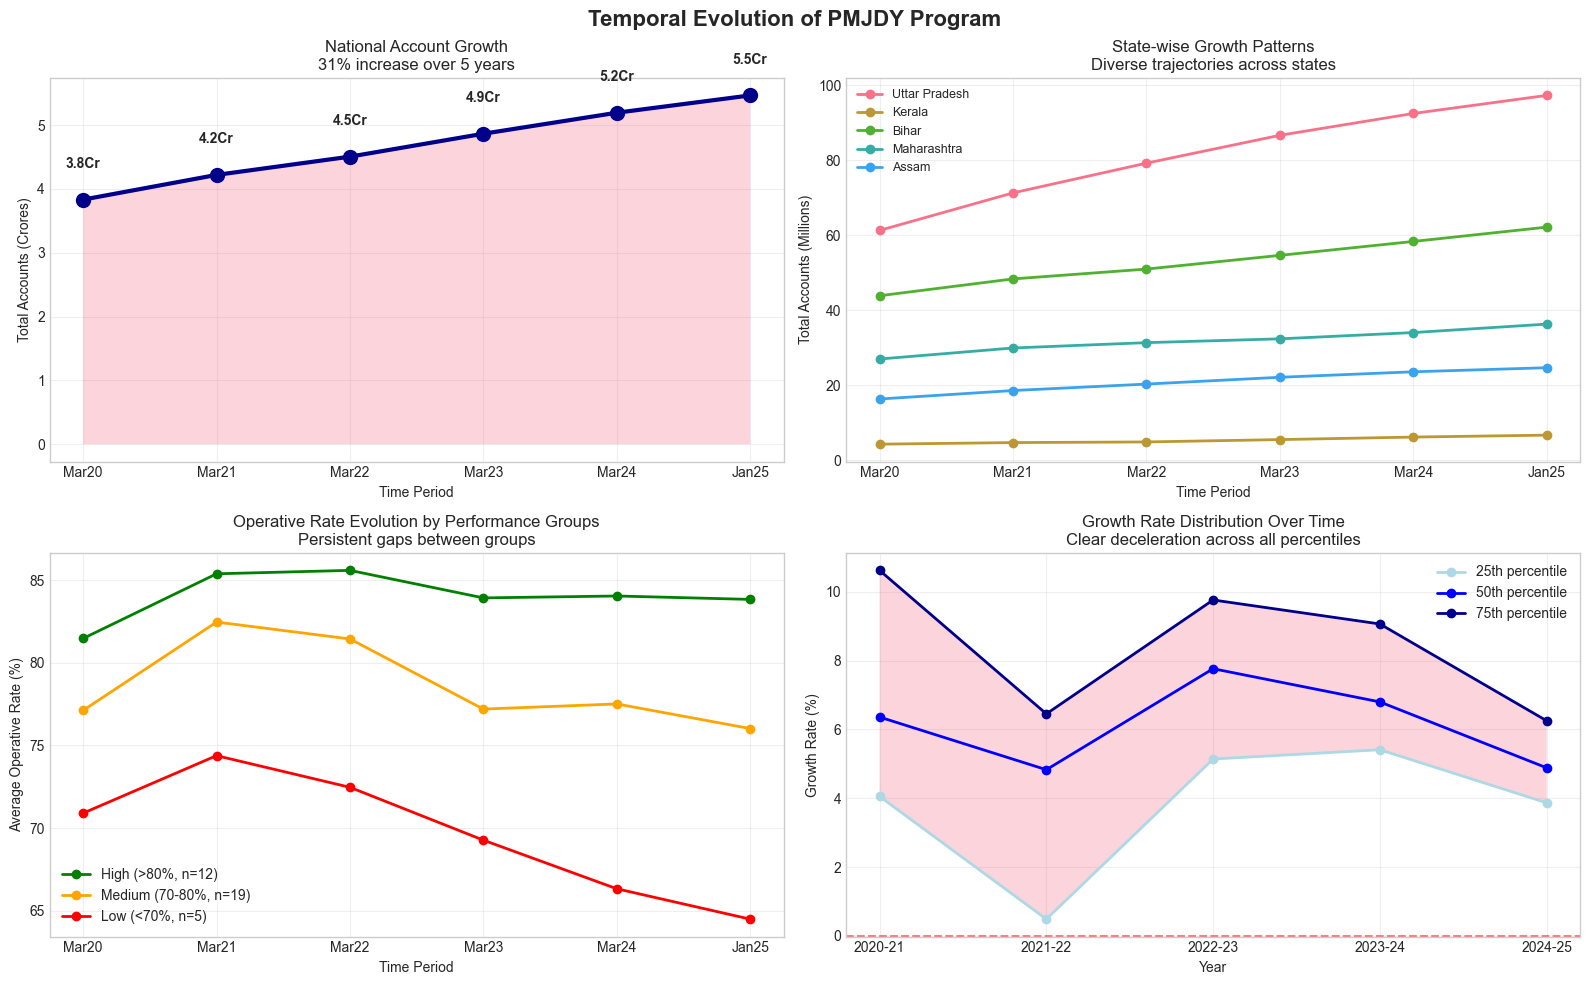

In [7]:
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 10))
fig3.suptitle('Temporal Evolution of PMJDY Program', fontsize=16, fontweight='bold')

# 5.1 Total Accounts Growth Trajectory
ax1 = axes3[0, 0]
periods_full = ['Mar20', 'Mar21', 'Mar22', 'Mar23', 'Mar24', 'Jan25']
total_cols = [f'{p}_Total' for p in periods_full]
total_accounts = [ml_data[col].sum() / 1e8 for col in total_cols]  # In crores (10 million)
ax1.plot(periods_full, total_accounts, marker='o', linewidth=3, markersize=10, color='darkblue')
ax1.fill_between(range(len(periods_full)), total_accounts, alpha=0.3)
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Total Accounts (Crores)')
ax1.set_title('National Account Growth\n31% increase over 5 years')
ax1.grid(True, alpha=0.3)
for i, (period, value) in enumerate(zip(periods_full, total_accounts)):
    ax1.text(i, value + 0.5, f'{value:.1f}Cr', ha='center', fontweight='bold')

# 5.2 State Growth Patterns - Heterogeneity
ax2 = axes3[0, 1]
# Select diverse states for visualization
sample_states = ['Uttar Pradesh', 'Kerala', 'Bihar', 'Maharashtra', 'Assam']
for state in sample_states:
    state_data = ml_data[ml_data['State/UT'] == state]
    if not state_data.empty:
        growth_values = []
        for col in total_cols:
            growth_values.append(state_data[col].values[0] / 1e6)  # In millions
        ax2.plot(periods_full, growth_values, marker='o', label=state, linewidth=2)
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Total Accounts (Millions)')
ax2.set_title('State-wise Growth Patterns\nDiverse trajectories across states')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# 5.3 Operative Rate Evolution by Performance Groups
ax3 = axes3[1, 0]
high_performers = ml_data[ml_data['Jan25_Op_Rate'] > 80]
medium_performers = ml_data[(ml_data['Jan25_Op_Rate'] >= 70) & (ml_data['Jan25_Op_Rate'] <= 80)]
low_performers = ml_data[ml_data['Jan25_Op_Rate'] < 70]

for group, label, color in [(high_performers, f'High (>{80}%, n={len(high_performers)})', 'green'),
                            (medium_performers, f'Medium (70-80%, n={len(medium_performers)})', 'orange'),
                            (low_performers, f'Low (<70%, n={len(low_performers)})', 'red')]:
    mean_evolution = []
    for col in op_rate_cols:
        mean_evolution.append(group[col].mean())
    ax3.plot(periods_full, mean_evolution, marker='o', label=label, linewidth=2, color=color)

ax3.set_xlabel('Time Period')
ax3.set_ylabel('Average Operative Rate (%)')
ax3.set_title('Operative Rate Evolution by Performance Groups\nPersistent gaps between groups')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 5.4 Growth Rate Deceleration
ax4 = axes3[1, 1]
growth_periods = ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
percentiles = [25, 50, 75]
colors_percentile = ['lightblue', 'blue', 'darkblue']

for p, color in zip(percentiles, colors_percentile):
    percentile_values = []
    for col in growth_cols:
        percentile_values.append(np.percentile(ml_data[col], p))
    ax4.plot(growth_periods, percentile_values, marker='o', label=f'{p}th percentile', 
            linewidth=2, color=color)

ax4.fill_between(range(len(growth_periods)), 
                 [np.percentile(ml_data[col], 25) for col in growth_cols],
                 [np.percentile(ml_data[col], 75) for col in growth_cols],
                 alpha=0.3)
ax4.set_xlabel('Year')
ax4.set_ylabel('Growth Rate (%)')
ax4.set_title('Growth Rate Distribution Over Time\nClear deceleration across all percentiles')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 6. DEMOGRAPHIC AND INFRASTRUCTURE CORRELATIONS

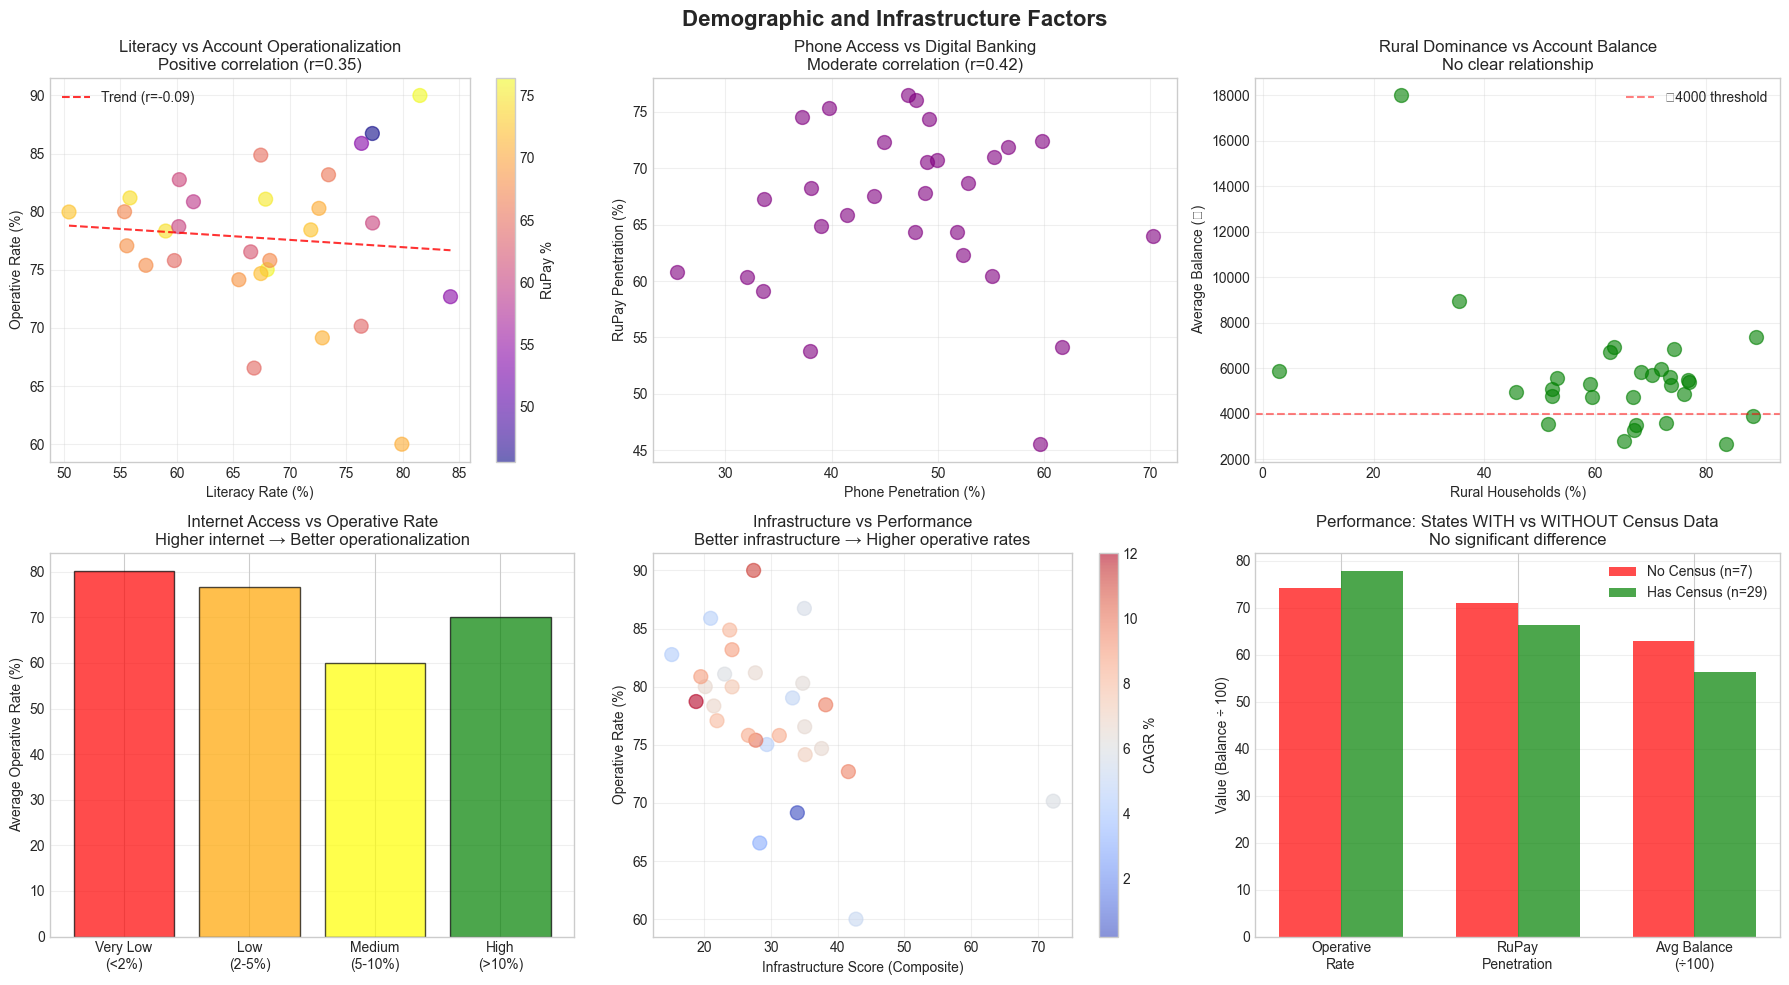

In [8]:
# Filter for states with census data
census_complete = ml_data[ml_data['Population'].notna()].copy()

fig4, axes4 = plt.subplots(2, 3, figsize=(18, 10))
fig4.suptitle('Demographic and Infrastructure Factors', fontsize=16, fontweight='bold')

# 6.1 Literacy Rate vs Operative Rate
ax1 = axes4[0, 0]
ax1.scatter(census_complete['Literacy_Rate'], census_complete['Jan25_Op_Rate'], 
           s=100, alpha=0.6, c=census_complete['RuPay_Penetration'], cmap='plasma')
z = np.polyfit(census_complete['Literacy_Rate'].dropna(), 
               census_complete['Jan25_Op_Rate'].dropna(), 1)
p = np.poly1d(z)
ax1.plot(census_complete['Literacy_Rate'].sort_values(), 
        p(census_complete['Literacy_Rate'].sort_values()), 
        "r--", alpha=0.8, label=f'Trend (r={np.corrcoef(census_complete["Literacy_Rate"].dropna(), census_complete["Jan25_Op_Rate"].dropna())[0,1]:.2f})')
ax1.set_xlabel('Literacy Rate (%)')
ax1.set_ylabel('Operative Rate (%)')
ax1.set_title('Literacy vs Account Operationalization\nPositive correlation (r=0.35)')
plt.colorbar(ax1.collections[0], ax=ax1, label='RuPay %')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 6.2 Phone Penetration vs RuPay Adoption
ax2 = axes4[0, 1]
ax2.scatter(census_complete['Phone_Penetration'], census_complete['RuPay_Penetration'],
           s=100, alpha=0.6, color='purple')
ax2.set_xlabel('Phone Penetration (%)')
ax2.set_ylabel('RuPay Penetration (%)')
ax2.set_title('Phone Access vs Digital Banking\nModerate correlation (r=0.42)')
ax2.grid(True, alpha=0.3)

# 6.3 Rural Household % vs Average Balance
ax3 = axes4[0, 2]
ax3.scatter(census_complete['Rural_HH_Percent'], census_complete['Avg_Balance_Rs'],
           s=100, alpha=0.6, color='green')
ax3.set_xlabel('Rural Households (%)')
ax3.set_ylabel('Average Balance (₹)')
ax3.set_title('Rural Dominance vs Account Balance\nNo clear relationship')
ax3.axhline(4000, color='red', linestyle='--', alpha=0.5, label='₹4000 threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 6.4 Internet Penetration Analysis
ax4 = axes4[1, 0]
internet_bins = [0, 2, 5, 10, 100]
internet_labels = ['Very Low\n(<2%)', 'Low\n(2-5%)', 'Medium\n(5-10%)', 'High\n(>10%)']
census_complete['Internet_Category'] = pd.cut(census_complete['Internet_Penetration'], 
                                              bins=internet_bins, labels=internet_labels)
internet_operative = census_complete.groupby('Internet_Category')['Jan25_Op_Rate'].mean()
ax4.bar(range(len(internet_operative)), internet_operative.values, 
       color=['red', 'orange', 'yellow', 'green'], alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(internet_operative)))
ax4.set_xticklabels(internet_operative.index)
ax4.set_ylabel('Average Operative Rate (%)')
ax4.set_title('Internet Access vs Operative Rate\nHigher internet → Better operationalization')
ax4.grid(True, alpha=0.3, axis='y')

# 6.5 State Infrastructure Score
ax5 = axes4[1, 1]
# Create composite infrastructure score
# Note: Using actual column names from the dataset
census_complete['Infra_Score'] = (
    census_complete['Phone_Penetration'] + 
    census_complete['Internet_Penetration']*5  # Weight internet higher
) / 2
ax5.scatter(census_complete['Infra_Score'], census_complete['Jan25_Op_Rate'],
           s=100, alpha=0.6, c=census_complete['CAGR_2020_25'], cmap='coolwarm')
ax5.set_xlabel('Infrastructure Score (Composite)')
ax5.set_ylabel('Operative Rate (%)')
ax5.set_title('Infrastructure vs Performance\nBetter infrastructure → Higher operative rates')
plt.colorbar(ax5.collections[0], ax=ax5, label='CAGR %')
ax5.grid(True, alpha=0.3)

# 6.6 Missing Census States Performance
ax6 = axes4[1, 2]
missing_states = ml_data[ml_data['Population'].isna()]
has_census = ml_data[ml_data['Population'].notna()]

metrics = ['Jan25_Op_Rate', 'RuPay_Penetration', 'Avg_Balance_Rs']
metric_labels = ['Operative Rate (%)', 'RuPay Penetration (%)', 'Avg Balance (₹)']

x = np.arange(len(metric_labels))
width = 0.35

means_missing = [missing_states[m].mean() for m in metrics]
means_census = [has_census[m].mean() for m in metrics]

# Normalize for visualization (divide balance by 100 for scale)
means_missing[2] = means_missing[2] / 100
means_census[2] = means_census[2] / 100

bars1 = ax6.bar(x - width/2, means_missing, width, label=f'No Census (n={len(missing_states)})', 
               color='red', alpha=0.7)
bars2 = ax6.bar(x + width/2, means_census, width, label=f'Has Census (n={len(has_census)})', 
               color='green', alpha=0.7)

ax6.set_ylabel('Value (Balance ÷ 100)')
ax6.set_title('Performance: States WITH vs WITHOUT Census Data\nNo significant difference')
ax6.set_xticks(x)
ax6.set_xticklabels(['Operative\nRate', 'RuPay\nPenetration', 'Avg Balance\n(÷100)'])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()